In [80]:
%matplotlib inline
import seaborn
import numpy, scipy, matplotlib.pyplot as plt, sklearn, IPython.display as ipd
import librosa, librosa.display

In [81]:
offset = 100
duration = 4

x, sr = librosa.load(r'C:\Dev\tools\WavFiles\Gareth Emery - Arrival (Ft. Brute Force) [pesnik.su].wav', offset=offset, duration=duration)
ipd.display(ipd.Audio(x, rate=sr))
print(x_trim)
onsets0To8 = numpy.asarray([0.020,0.375,0.730,0.845,0.965,1.080,1.315,1.665,1.900,2.250,2.505,2.605,2.720,2.840,2.955,3.190,3.540,3.775,4.020,4.125,4.380,4.480,4.595,4.715,4.830,5.065,5.305,5.415,5.650,6.000,6.245,6.355,6.470,6.590,6.705,6.940,7.180,7.290,7.525,7.765,7.875])
onsets100To104 = numpy.asarray([100.110,
100.225,
100.335,
100.575,
100.615,
100.695,
100.805,
100.930,
101.045,
101.165,
101.270,
101.515,
101.630,
101.745,
101.980,
102.100,
102.210,
102.450,
102.570,
102.680,
102.920,
103.150,
103.390,
103.510,
103.620,
103.860,
103.980])
onsets = onsets100To104-100
print(onsets.shape[0])
print(onsets)

[-0.08993312 -0.09751468 -0.05081615]
27
[ 0.11   0.225  0.335  0.575  0.615  0.695  0.805  0.93   1.045  1.165
  1.27   1.515  1.63   1.745  1.98   2.1    2.21   2.45   2.57   2.68   2.92
  3.15   3.39   3.51   3.62   3.86   3.98 ]


In [72]:
beepDuration = 0.1   # in seconds, may be float
f = 1000.0        # sine frequency, Hz, may be float
beep = (numpy.sin(2*numpy.pi*numpy.arange(sr*beepDuration)*f/sr)).astype(numpy.float32)
print(beep)
ipd.display(ipd.Audio(beepDuration, rate=sr))

[ 0.          0.28111112  0.53955072 ..., -0.75447583 -0.53955072
 -0.28111112]


ValueError: Array audio input must be a 1D or 2D array

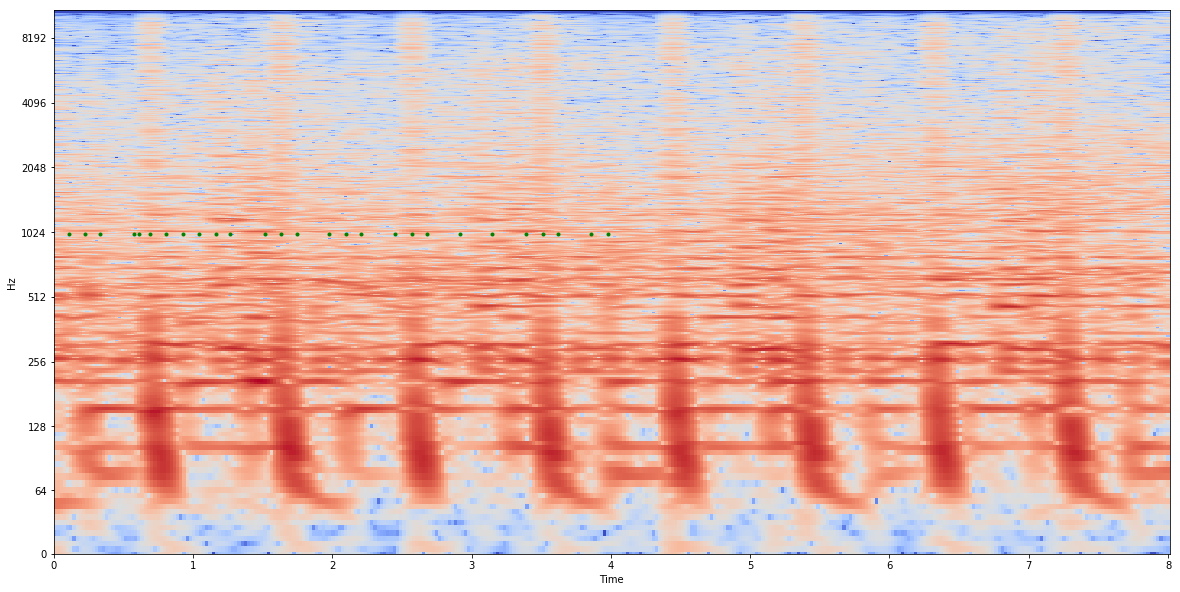

In [73]:
hop_length = 256
n_fft = 4096
X = librosa.stft(x, n_fft=n_fft, hop_length=hop_length)
S = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(20, 10))
librosa.display.specshow(S, sr=sr, x_axis='time', y_axis='log')
onsetLines = numpy.full(onsets100To104.shape[0], 1000)
plt.scatter(onsets100To104-100,onsetLines,color='g',marker='.')

In [79]:
clicks = librosa.clicks(frames=onsets, sr=sr, length=len(x))
ipd.Audio(x + clicks, rate=sr)